This code is to plot the graphs for our findings.

In [4]:
#Importing lib's
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
#Loading the data
limnology_file = r"S:\Sem_4\Output\cleaned_limnology_data.xlsx"
enriched_file = r"S:\Sem_4\Output\enriched_lake_data.xlsx"

df_lim = pd.read_excel(limnology_file)
df_enriched = pd.read_excel(enriched_file)

In [9]:
#Standardizing the lake names
df_lim['lake_name'] = df_lim['lake_name'].astype(str).str.title().str.replace('_', ' ').str.strip()
df_enriched['lake_name'] = df_enriched['lake_name'].astype(str).str.title().str.replace('_', ' ').str.strip()

In [10]:
#Converting date column to datetime objects
df_lim['date'] = pd.to_datetime(df_lim['date'])

#Creating a numeric date column for regression (ordinal date)
df_lim['date_ordinal'] = df_lim['date'].apply(lambda x: x.toordinal())

In [11]:
#Creating a function to calculate trends
def calculate_trend(group):
    #Drop missing phosphorus values
    group = group.dropna(subset=['average_phosphorus_(mg/l)'])

    #We need at least 2 data points to calculate a trend
    if len(group) < 2:
        return np.nan

    #Perform linear regression: y = Phosphorus, x = Date
    slope, intercept, r_value, p_value, std_err = linregress(group['date_ordinal'], group['average_phosphorus_(mg/l)'])

    #Slope is change per day; multiply by 365 to get change per year
    return slope * 365

In [13]:
#Applying the function to each lake
cols_needed = ['date_ordinal', 'average_phosphorus_(mg/l)']

trend_series = df_lim.groupby('lake_name')[cols_needed].apply(calculate_trend)
trend_df = trend_series.reset_index(name='phosphorus_trend_per_year')

In [15]:
#Merging the calculated trends into the main enriched dataframe
df_analysis = pd.merge(df_enriched, trend_df, on='lake_name', how='left')

In [16]:
#Correlation analysis

#Selecting columns for correlation
#Morphometry/Development (Drivers)
drivers = [
    'num_properties',
    'surface_area_ha',
    'max_depth_m',
    'watershed_area_ha',
    'Shoreline Length (km)'
]

#Status & Trends (Responses)
responses = [
    'average_phosphorus_(mg/l)',
    'secchi_depth',
    'conductivity_(us/cm)',
    'phosphorus_trend_per_year'
]

#Creating Correlation Matrix
cols_of_interest = drivers + responses
#Only include those columns that actually exist in the dataframe
cols_of_interest = [c for c in cols_of_interest if c in df_analysis.columns]

corr_matrix = df_analysis[cols_of_interest].corr()

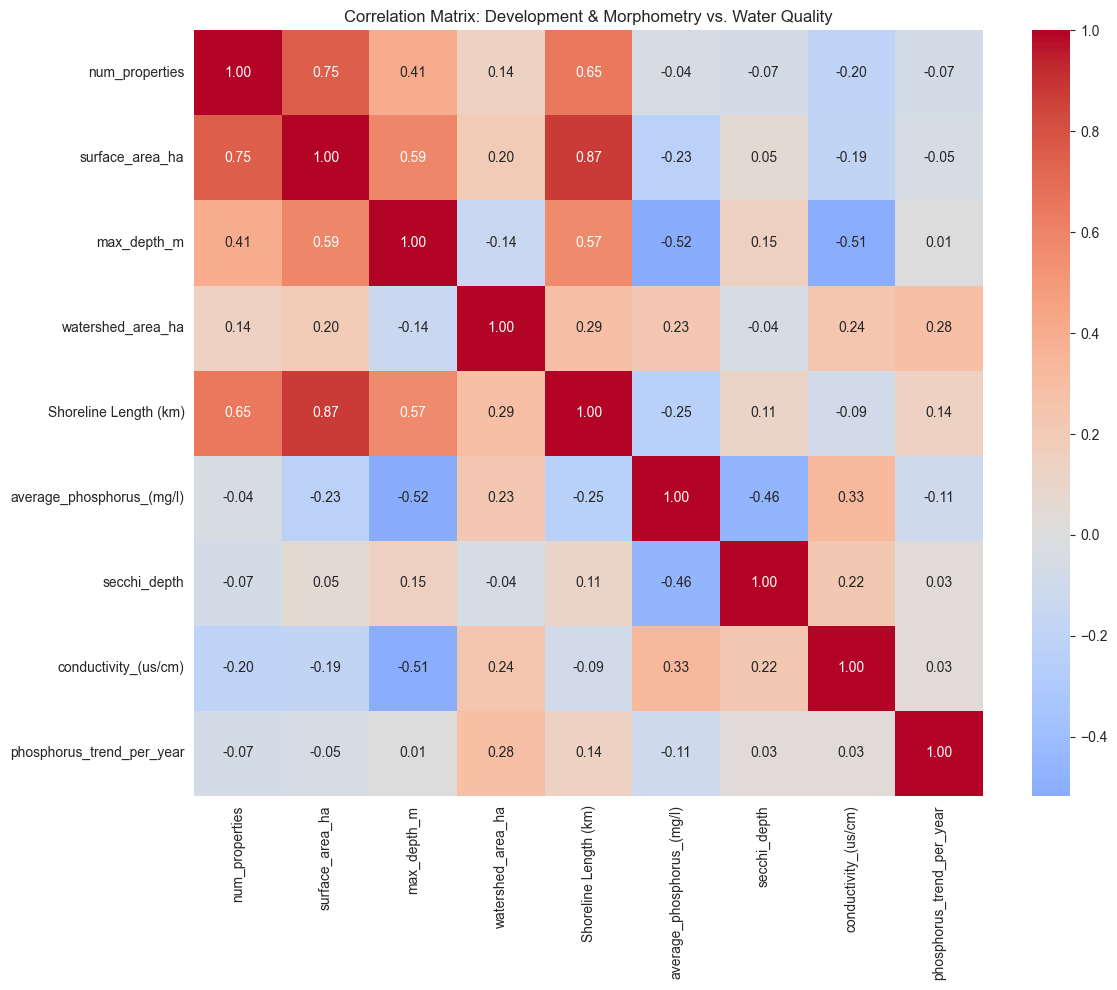

In [23]:
#PLotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Correlation Matrix: Development & Morphometry vs. Water Quality')
plt.tight_layout()
output_path = r'S:\Sem_4\Output\Correlation_Matrix.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

In [18]:
#Group Comparisons

#Categorizing lakes into "Deep" vs "Shallow" based on median depth
median_depth = df_analysis['max_depth_m'].median()
df_analysis['Depth_Class'] = np.where(df_analysis['max_depth_m'] > median_depth, 'Deep', 'Shallow')

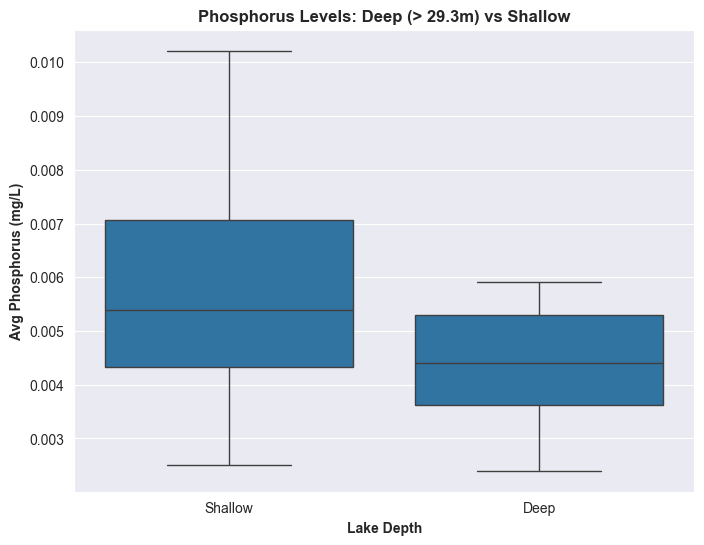

In [28]:
#Boxplot: Phosphorus by Depth
plt.figure(figsize=(8, 6))
sns.boxplot(x='Depth_Class', y='average_phosphorus_(mg/l)', data=df_analysis)
plt.title(f'Phosphorus Levels: Deep (> {median_depth}m) vs Shallow', fontweight='bold')
plt.ylabel('Avg Phosphorus (mg/L)', fontweight='bold')
plt.xlabel('Lake Depth', fontweight='bold')
output_path = r'S:\Sem_4\Output\Phosphorus_Levels_Deep_vs_Shallow.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

In [20]:
#Categorizing lakes into "Large" vs "Small" based on median surface area
median_area = df_analysis['surface_area_ha'].median()
df_analysis['Size_Class'] = np.where(df_analysis['surface_area_ha'] > median_area, 'Large', 'Small')

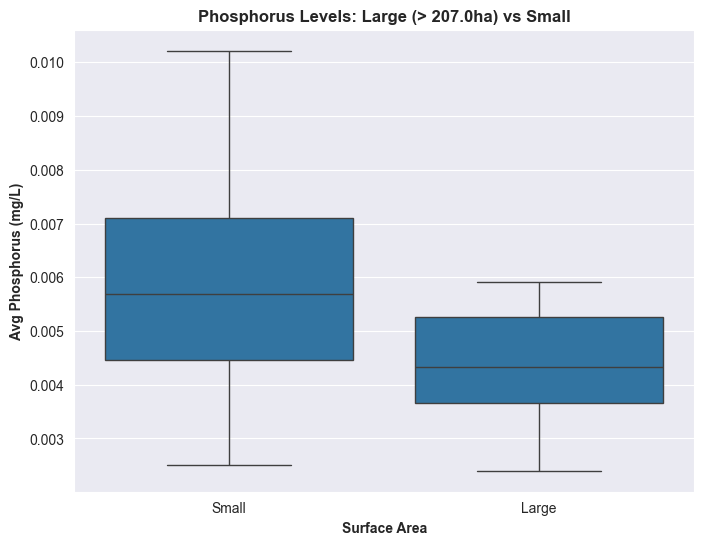

In [29]:
#Boxplot: Phosphorus by Lake Size
plt.figure(figsize=(8, 6))
sns.boxplot(x='Size_Class', y='average_phosphorus_(mg/l)', data=df_analysis)
plt.title(f'Phosphorus Levels: Large (> {median_area}ha) vs Small', fontweight='bold')
plt.ylabel('Avg Phosphorus (mg/L)', fontweight='bold')
plt.xlabel('Surface Area', fontweight='bold')
output_path = r'S:\Sem_4\Output\Phosphorus_Levels_Large_vs_Small.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

In [22]:
print("--- Correlation with Phosphorus Trends ---")
print(corr_matrix['phosphorus_trend_per_year'].sort_values(ascending=False))

--- Correlation with Phosphorus Trends ---
phosphorus_trend_per_year    1.000000
watershed_area_ha            0.284627
Shoreline Length (km)        0.141234
conductivity_(us/cm)         0.031595
secchi_depth                 0.031320
max_depth_m                  0.008748
surface_area_ha             -0.046352
num_properties              -0.073576
average_phosphorus_(mg/l)   -0.106730
Name: phosphorus_trend_per_year, dtype: float64
